# Task 1: Generate a Synthetic Dataset
This section is devoted to the creation of an artificial dataset. First of all, \
I need to create a set (the bigger the better) of distinct original names, \
which later on would be mutatd according to the rules specified in the assignment.

## Exploration
Let's see the data and decide whether we need additional datasets/sources.

### Kaggle Resume Dataset
[This dataset](https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset) contains resumes for certain positions.

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

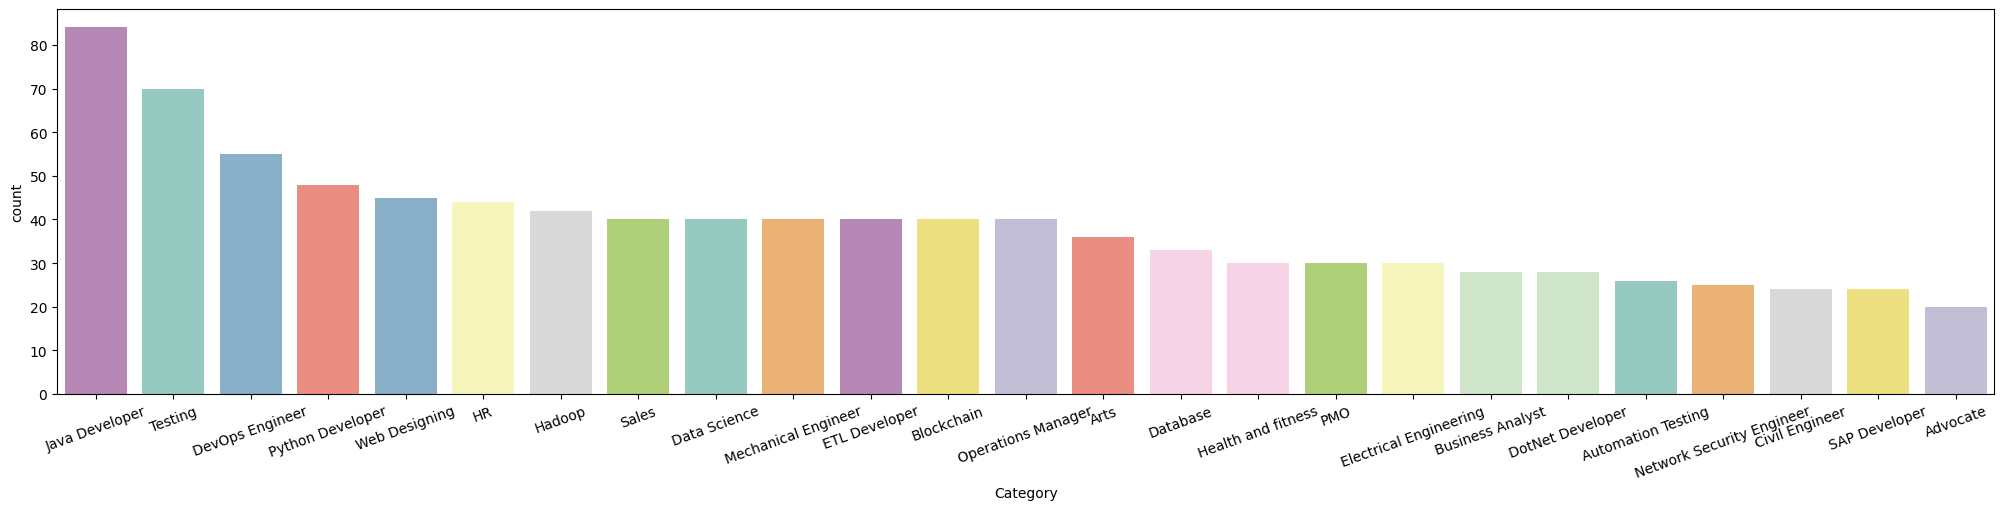

In [2]:
df = pd.read_csv(Path("./raw_data/kaggle_resumes.csv"))

plt.figure(figsize=(25, 5))
sns.countplot(
    data=df,
    x="Category",
    order=df["Category"].value_counts().index,
    palette="Set3",
    hue="Category",
)
plt.xticks(rotation=20);

In [3]:
df["Category"].value_counts().shape

(25,)

Kaggle Resume Dataset seems emough for the required `Aim for a few thousand rows`. It seems small, \
but adding seniority levels and otherwise augmenting the dataset can produce up `(25 * 4)**2` rows \
for 4 seniority levels. Nonetheless, let's see another one to understand what we're working with. 

### Kaggle Indeed Job Posting Dataset

[This dataset](https://www.kaggle.com/datasets/promptcloud/indeed-job-posting-dataset/data) contains organized resumes.

In [4]:
df2 = pd.read_csv(Path("./raw_data/kaggle_indeed.csv"))


In [5]:
df2

,Job Title,Job Description,Job Type,Categories,Location,City,State,Country,Zip Code,Address,...,Employer Phone,Employer Logo,Companydescription,Employer Location,Employer City,Employer State,Employer Country,Employer Zip Code,Uniq Id,Crawl Timestamp
0,Shift Manager,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Mission Hills, CA 91345",Mission Hills,CA,United States,91345,NaN,...,NaN,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,Del Taco is an American quick service restaura...,"Mission Hills, CA 91345",Mission Hills,CA,United States,91345,511f9a53920f4641d701d51d3589349f,2019-08-24 09:13:18 +0000
1,Operations Support Manager,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Atlanta, GA 30342",Atlanta,GA,United States,30342,NaN,...,NaN,https://d2q79iu7y748jz.cloudfront.net/s/_logo/...,"Based in Atlanta, FOCUS Brands Inc. is an inno...",NaN,NaN,NaN,United States,NaN,4955daf0a3facbe2acb6c429ba394e6d,2019-09-19 08:16:55 +0000
2,Senior Product Manager - Data,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Chicago, IL",Chicago,IL,United States,NaN,NaN,...,NaN,NaN,Vibes Corp. reputation was built and establish...,NaN,NaN,NaN,United States,NaN,a0e0d12df1571962b785f17f43ceae12,2019-09-18 02:13:10 +0000
3,Part-Time Office Concierge,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Festus, MO",Festus,MO,United States,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,56e411fd731f76ac916bf4fb169250e9,2019-10-24 16:39:13 +0000
4,Print & Marketing Associate,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Cedar Rapids, IA 52404",Cedar Rapids,IA,United States,52404,NaN,...,NaN,https://d2q79iu7y748jz.cloudfront.net/s/_logo/...,"Staples is The Worklife Fulfillment Company, h...","Cedar Rapids, IA 52404",Cedar Rapids,IA,United States,52404,3fff5c0ad6981bf4bff6260bd5feab63,2019-08-24 22:29:10 +0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29997,Bilingual Teller,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Lakewood, CO 80226",Lakewood,CO,United States,80226,NaN,...,NaN,https://d2q79iu7y748jz.cloudfront.net/s/_logo/...,Moneytree is a family-run business that has be...,NaN,NaN,NaN,United States,NaN,db18d0e2de28df6e1e605a3800ffd574,2019-10-25 22:42:37 +0000
29998,"Rental Consultant - Harrison, OH","<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Harrison, OH 45030",Harrison,OH,United States,45030,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,47f8d7f320223b6f043ef5c345676902,2019-10-25 16:56:18 +0000
29999,Product Support Specialist 5,"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"Melbourne, FL 32940",Melbourne,FL,United States,32940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,United States,NaN,d2a18fb9f52495aa7876d4470e5acc61,2019-10-25 01:39:48 +0000
30000,Marketing Strategist (Contract),"<div id=""jobDescriptionText"" class=""jobsearch-...",NaN,NaN,"San Diego, CA",San Diego,CA,United States,NaN,NaN,...,NaN,https://d2q79iu7y748jz.cloudfront.net/s/_logo/...,Ajinomoto Bio-Pharma Services is a fully integ...,NaN,NaN,NaN,United States,NaN,ce699d2e94a52dfebb13bcf70ed5ffd7,2019-08-23 15:36:47 +0000


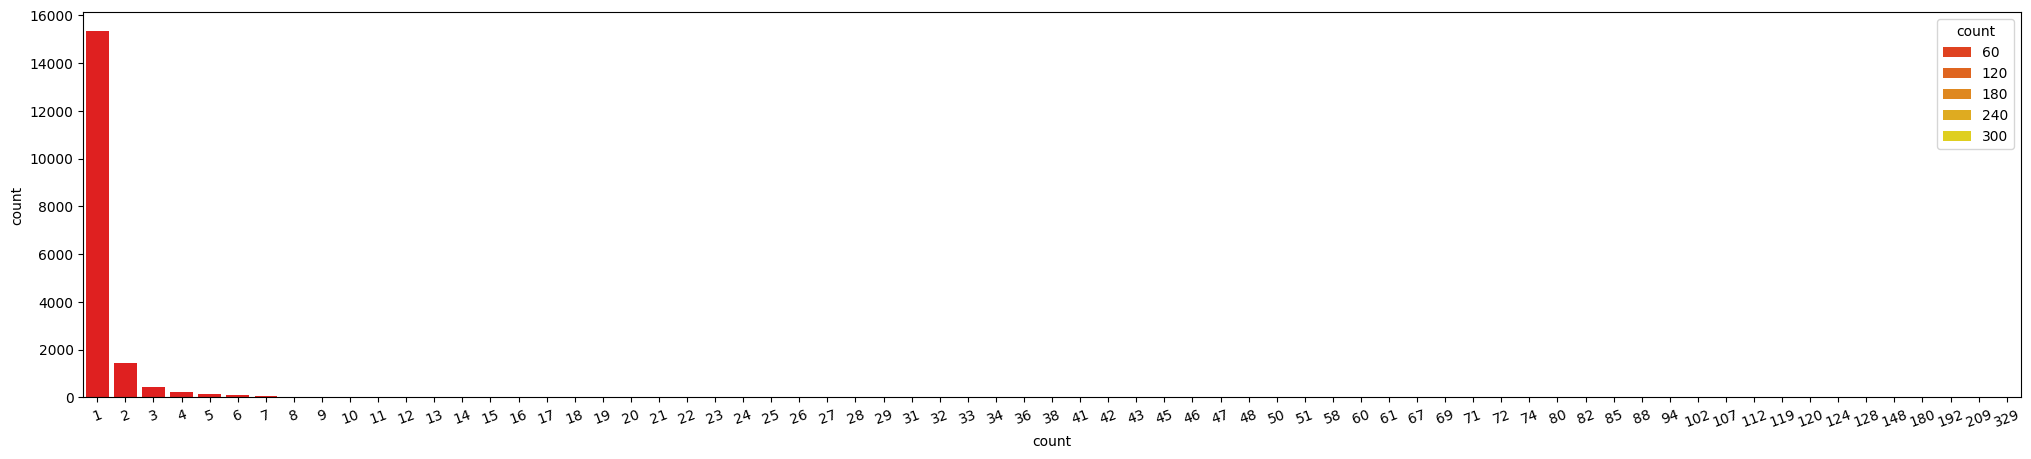

In [6]:
import numpy as np

plt.figure(figsize=(25, 5))
sns.countplot(
    data=df2["Job Title"].value_counts().reset_index(),
    x="count",
    palette="autumn",
    hue="count"
)
plt.xticks(rotation=20);


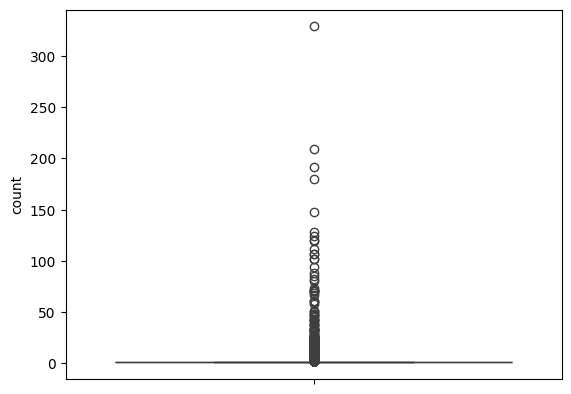

In [7]:
sns.boxplot(df2["Job Title"].value_counts());

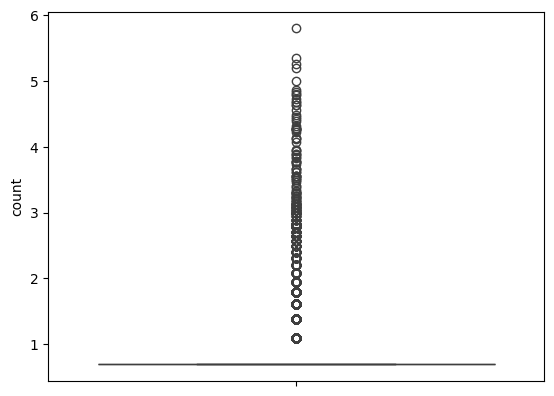

In [8]:
sns.boxplot(df2["Job Title"].value_counts().apply(np.log1p));

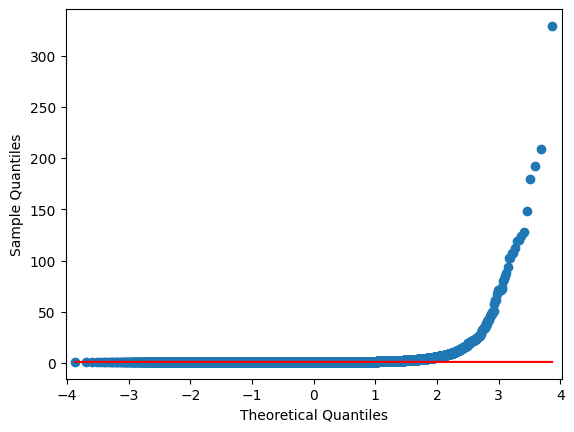

In [9]:
import statsmodels.api as sm


sm.qqplot(df2["Job Title"].value_counts(), line='q');

The data is severly skewed to the rear instances. One choice could be picking the most \
common job titles, however the state of the dataset indicates its poor state. I would suggest \
returning to it later in case of necessity. Until then let's build the pipeline with the data at hand. 

## Data Generation

In [10]:
import numpy as np
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
import itertools
from tqdm.auto import tqdm
import random

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')


default_save_path = Path("./dataset.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anthony\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's load a pretrained NER model for spacy, that would allow easier markup of the titles. \
Later on I would suggest combining large POS models ith more suffisticated NER models for a better markup. \
In this noteook it's failed since the module is already installed.

In [11]:
! git lfs install
! git clone https://huggingface.co/LPDoctor/en_core_web_sm_job_related

Git LFS initialized.


fatal: destination path 'en_core_web_sm_job_related' already exists and is not an empty directory.


In [28]:
class DataRuler:
    """Handles and stores the rules' logic.

    Applies NER models and handles verification process. Serves as the base for a generator object.
    """

    none_labels = [
        "none",
        "n/a",
        "na",
        "null",
        "",
        "missing",
    ]
    none_labels += [label.capitalize() for label in none_labels]
    none_labels += [label.upper() for label in none_labels]

    seniority_labels = [
        "sr",
        "senior",
        "jr",
        "junior",
        "lead",
        "intern",
        "mid",
        "middle",
        "trainee",
    ]
    seniority_hierarchy_mapping = {
        "sr": 3,
        "senior": 3,
        "jr": 1,
        "junior": 1,
        "lead": 4,
        "intern": 0,
        "mid": 2,
        "middle": 2,
        "trainee": 0,
    }
    seniority_labels += [label.capitalize() for label in seniority_labels]

    field_generics = [
        "data",
        "software",
        "devops",
        "etl",
        "qa",
        "product",
        "system",
        "network",
        "security",
        "database",
        "HR",
        "design",
        "marketing",
        "sales",
        "finance",
        "business",
        "designing",
        "blockchain",
        "testing",
        "automation",
        "arts",
        "health",
        "healthcare",
        "education",
        "construction",
        "fitness",
    ]
    field_generics += [field.capitalize() for field in field_generics]

    job_generics = [
        "engineer",
        "developer",
        "scientist",
        "manager",
        "administrator",
        "analyst",
        "designer",
        "tester",
        "consultant",
        "advocate",
    ]
    job_generics += [job.capitalize() for job in job_generics]

    _rule1_identifier = "Rule 1 (Missing Title)"
    _rule3_identifier = "Rule 3 (Exact / near match)"
    _rule4_identifier = "Rule 4 (Hierarchy / seniority difference)"
    _rule5_identifier = "Rule 5 (Departmental / generic vs specific)"
    _rule6_identifier = "Rule 6 (Invalid title)"
    _rule7_identifier = "Rule 7 (Different job family)"

    def _add_patterns(self):
        """Add patterns to the entity ruler of the self.job_nlp model."""
        ruler1 = self.job_nlp.add_pipe("entity_ruler", before="ner")
        ruler2 = self.nlp.add_pipe("entity_ruler", before="ner")

        patterns = [
            {"label": "SENIORITY", "pattern": exp} for exp in self.seniority_labels
        ]
        patterns += [
            {"label": "PROFESSION", "pattern": job} for job in self.job_generics
        ]
        patterns += [{"label": "FIELD", "pattern": job} for job in self.field_generics]
        patterns += [{"label": "NONE", "pattern": label} for label in self.none_labels]

        ruler1.add_patterns(patterns)
        ruler2.add_patterns(patterns)

    def __init__(
        self,
        upper_similarity_threshold: float = 0.9,
        lower_similarity_threshold: float = 0.5,
    ):
        self.upper_similarity_threshold = upper_similarity_threshold
        self.lower_similarity_threshold = lower_similarity_threshold

        # setup spacy models
        self.nlp = spacy.load("en_core_web_lg")
        self.job_nlp = spacy.load(".\en_core_web_sm_job_related")

        self._add_patterns()

        # comprise stopwords and punctuation for normalization
        self.stop_words = set(stopwords.words("english")) | set(string.punctuation)

    def _get_seniority_labels(self, title: str):
        """Returns seniority labels from the title in the order of appearence."""
        return [
            ent.text.lower()
            for ent in self.job_nlp(title).ents
            if ent.label_ == "SENIORITY"
        ]

    def rule1(self, title1: str, title2: str) -> bool:
        """Check if the job title is NONE.

        Missing Title → verified. If either title is null, “n/a”, or “missing”, mark as verified.

        Parameters
        ----------
        title1 : str
            Should be normalized.
        title1 : str
            Should be normalized.

        Returns
        -------
        bool
            True if a title is considered as None, False otherwise.
        """
        return (self.job_nlp(str(title1).strip()) == "NONE") or (
            self.job_nlp(str(title2).strip()) == "NONE"
        )

    def rule2(self, title: str) -> str:
        """Remove company names, locations, and incomplete words.

        Normalizes raw titles. Beside deleteing company names and locations, also removes stopwords and punctuation.

        Parameters
        ----------
        title : str
            raw title to be normalized.

        Returns
        -------
        str
            normalized title
        """
        text = str(title).strip()

        # remove entities recognized as ORG, GPE or LOC
        doc = self.nlp(text)
        for ent in doc.ents:
            if ent.label_ in {"ORG", "GPE", "LOC"}:
                text = text.replace(ent.text, "").replace("  ", " ")

        # remove stopwords and punctuation
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token.lower() not in self.stop_words]
        text = " ".join(tokens)

        return text.replace("  ", " ").strip()

    def rule3(self, title1: str, title2: str) -> bool:
        """Check if two job titles are similar enough by upper bound.

        If cleaned titles are identical or very close (e.g., ≥ 0.9 similarity), mark verified.
        Consideres average of the word embeddings similarity of two titles on different models.

        Seniority label is removed before calculating similarity, so that the seniority coherence
        is controled solely by the rule 4.

        Parameters
        ----------
        title1 : str
            The first job title.
        title2 : str
            The second job title.

        Returns
        -------
        bool
            True if the two titles are similar enough by upper bound, False otherwise.
        """
        similarity = 0.0
        seniority_labels1 = self._get_seniority_labels(title1)
        seniority_labels2 = self._get_seniority_labels(title2)

        for label in seniority_labels1:
            title1 = title1.replace(label, "").strip()
        for label in seniority_labels2:
            title2 = title2.replace(label, "").strip()

        for model in self.nlp, self.job_nlp:
            doc1 = model(title1.lower())
            doc2 = model(title2.lower())
            similarity += doc1.similarity(doc2)

        return similarity / 2.0 >= self.upper_similarity_threshold

    def rule4(self, title1: str, title2: str) -> bool:
        """Check if two job titles have the same seniority level.

        Hierarchy / seniority difference → discrepancy. Seniority levels, their order,
        and quantity must match. Multiple seniority cases' support is preserved for cases like
        "Senior Data Engineer / Lead Python Developer" and "Senior Software Engineer / Lead Python Engineer".

        The idea is to extract seniority entities from both titles and compare them regardless of other parts of the titles.

        Parameters
        ----------
        title1 : str
            Should be normalized.
        title2 : str
            Should be normalized.

        Returns
        -------
        bool
            True if the two titles have the same seniority levels, False otherwise.
        """

        doc1_seniority_entities = self._get_seniority_labels(title1)
        doc2_seniority_entities = self._get_seniority_labels(title2)

        doc1_seniority_levels = [
            self.seniority_hierarchy_mapping[label] for label in doc1_seniority_entities
        ]
        doc2_seniority_levels = [
            self.seniority_hierarchy_mapping[label] for label in doc2_seniority_entities
        ]

        return doc1_seniority_levels == doc2_seniority_levels

    def rule5(self, title1: str, title2: str) -> bool:
        """Checks if one side is a department or generic term (Sales, Associate, Specialist)

        Departmental / generic vs specific → verified. Since a normalized string here can only be
        an incorrect title or a generic term, if one side is generic while the other is specific,
        they are considered different. Otherwise they are either both a generic / incorrect title
        or both specific titles.

        According to the descriptyion above, this rule 5's implementation might overlap (but not contradict)
        with the rule 6 implementation. Please refer it for further details.

        Parameters
        ----------
        title1 : str
            should be normalized
        title2 : str
            should be normalized

        Returns
        -------
        bool
            True if both sides are generic / incorrect titles or both specific titles, False otherwise.
        """
        labels1 = [ent.label_ for ent in self.job_nlp(title1).ents]
        labels2 = [ent.label_ for ent in self.job_nlp(title2).ents]

        return "PROFESSION" in labels1 == "PROFESSION" in labels2

    def rule6(self, title1: str, title2: str) -> bool:
        """Check if some job title is incorrect.

        Invalid title → verified. Since any title not actually containing a profession is invalid,
        if at least one side lacks a profession entity, the rule leads to verification.

        Parameters
        ----------
        title1 : str
            should be normalized
        title2 : str
            should be normalized

        Returns
        -------
        bool
            True if at least one title is invalid, False otherwise.
        """
        labels1 = [ent.label_ for ent in self.job_nlp(title1).ents]
        labels2 = [ent.label_ for ent in self.job_nlp(title2).ents]

        return "PROFESSION" not in labels1 or "PROFESSION" not in labels2

    def rule7(self, title1: str, title2: str) -> bool:
        """Check if two job titles are similar enough by lower bound.

        Different job family → discrepancy.
        Consideres average of the word embeddings similarity of two titles on different models.

        PLEASE NOTE, that making this rule work perfectly, I would need either a pretrained model,
        or a to build the dataset on deterministic rules, which I am going to implement in other stages.
        This rule, however, provides a basic implementation for the markup in the pipeline, and could
        be later enhanced with the trained model to iteratively improve each model by prior models' outputs.

        I would definitely suggest training multiple lightweight models and putting them in this stage
        to create a more robust ensemble model for this task.

        Seniority label is removed before calculating similarity, so that the seniority coherence
        is controled solely by the rule 4.

        Parameters
        ----------
        title1 : str
            should be normalized.
        title2 : str
            should be normalized.

        Returns
        -------
        bool
            True if the two titles are similar enough by lower bound, False otherwise.
        """
        similarity = 0.0
        seniority_labels1 = self._get_seniority_labels(title1)
        seniority_labels2 = self._get_seniority_labels(title2)

        for label in seniority_labels1:
            title1 = title1.replace(label, "").strip()
        for label in seniority_labels2:
            title2 = title2.replace(label, "").strip()

        for model in self.nlp, self.job_nlp:
            doc1 = model(title1.lower())
            doc2 = model(title2.lower())
            similarity += doc1.similarity(doc2)

        return similarity / 2.0 >= self.lower_similarity_threshold

    def rules_summary(self, title1: str, title2: str) -> tuple[bool, str]:
        """Summary of all rules.

        The overall logic for the rules is if they lead to discrepancy, they return False.
        None of the rules directly contradict one another, except for rule4, which has undefined
        behavior when the seniority levels don't match and the job titles are otherwise corrupt.
        Set above other rules in the logic, since if the seniority fails, whatever title is
        substituted instead of the corrupt one, the discrepancy remains.

        Rule 7 is set as last priority, since it's not mutually exclusive with `positive`
        rules 1, 3, 5 and 6. Meaning, a corrupt title is likely to have low similarity, while
        satisfying other verification rules.

        Of 7 rules there're 4 positive (verification) rules (1, 3, 5, 6) and 2 negative
        (discrepancy) rules (4, 7). Therefore, some pairs won't be directly classified based
        on the rules. For this case `No rules matched` is returned.


        Parameters
        ----------
        title1 : str
            should be normalized.
        title2 : str
            should be normalized.

        Returns
        -------
        tuple[bool, str]
            (`True for match (verified), False for discrepancy`, `Rule identifier`)
        """

        positive_rules = (
            self.rule1(title1, title2),
            self.rule3(title1, title2),
            self.rule5(title1, title2),
            self.rule6(title1, title2),
        )

        if any(positive_rules):
            identifiers = (
                self._rule1_identifier,
                self._rule3_identifier,
                self._rule5_identifier,
                self._rule6_identifier,
            )
            first_positive_id = str(np.array(identifiers)[np.array(positive_rules)][0])
            return True, first_positive_id

        rule4_result = self.rule4(title1, title2)
        if not rule4_result:
            return False, self._rule4_identifier

        if not self.rule7(title1, title2):
            return False, self._rule7_identifier

        return False, "No rules matched"


class DataGenerator(DataRuler):
    def __init__(
        self,
        upper_similarity_threshold: float = 0.9,
        lower_similarity_threshold: float = 0.5,
    ):
        super().__init__(upper_similarity_threshold, lower_similarity_threshold)

    def generate(
        self,
        raw_job_titles: list[str],
        expected_size: int = None,
        repeatable=False,
        save_path: Path = default_save_path,
        random_state: int = 42,
        prioritize_discrepancy: bool = False,
    ) -> pd.DataFrame:
        random.seed(random_state)

        # derive appropriate dataset size
        basic_seniority_labels = {label.lower() for label in self.seniority_labels}
        basic_seniority_labels_size = len(basic_seniority_labels)
        max_dataset_size = (
            (len(raw_job_titles) * (basic_seniority_labels_size + 1))
            * (len(raw_job_titles) * (basic_seniority_labels_size + 1) - 1)
        ) / 2

        if (
            expected_size is not None
            and max_dataset_size < expected_size
            and not repeatable
        ):
            raise ValueError(
                "Expected size is too big for the number of raw job titles."
            )

        normalized_titles = list({self.rule2(title) for title in raw_job_titles})
        max_dataset_size = (
            (len(normalized_titles) * (basic_seniority_labels_size + 1))
            * (len(normalized_titles) * (basic_seniority_labels_size + 1) - 1)
        ) / 2

        if expected_size is None:
            expected_size = max_dataset_size

        if max_dataset_size < expected_size:
            raise ValueError(
                f"Expected size is too big for the number of raw job titles. Must be at most {max_dataset_size}."
            )

        # generate combinations
        enhanced_titles = list(
            itertools.chain(
                [
                    f"{label} {title}".strip().lower()
                    for label in ["", *basic_seniority_labels]
                    for title in normalized_titles
                ]
            )
        )
        expected_size = min(
            (len(enhanced_titles) * (len(enhanced_titles) - 1)) // 2, expected_size
        )
        combs = itertools.combinations(enhanced_titles, 2)

        # assemble into a dataset
        if prioritize_discrepancy:
            verified_data = []
            discrepancy_data = []
            for comb in tqdm(list(combs), desc="Calculating total data"):
                chunk = (*comb, *self.rules_summary(*comb))
                if chunk[2]:
                    verified_data.append(chunk)
                else:
                    discrepancy_data.append(chunk)

            discrepancy_expected_size = min(len(discrepancy_data), expected_size // 2)
            remaining_expected_size = expected_size - discrepancy_expected_size

            data = random.sample(
                verified_data, k=remaining_expected_size
            ) + random.sample(discrepancy_data, k=discrepancy_expected_size)
        else:
            data = (
                (*comb, *self.rules_summary(*comb))
                for comb in tqdm(random.sample(list(combs), k=expected_size))
            )
        dataset = pd.DataFrame(data, columns=["applicant_job_title", "official_record_job_title", "status", "rule"])

        # save the dataset
        save_path.parent.mkdir(parents=True, exist_ok=True)
        dataset.to_csv(save_path)
        return dataset


gen = DataGenerator()
dataset = gen.generate(["N/A", *df["Category"].unique().tolist()], expected_size=10000, prioritize_discrepancy=True)
dataset

Calculating total data:   0%|          | 0/21945 [00:00<?, ?it/s]

,applicant_job_title,official_record_job_title,status,rule
0,jr,lead data science,True,Rule 6 (Invalid title)
1,database,middle n/a,True,Rule 6 (Invalid title)
2,senior testing,lead data science,True,Rule 6 (Invalid title)
3,senior hr,lead hr,True,Rule 3 (Exact / near match)
4,senior database,sr network security engineer,True,Rule 6 (Invalid title)
...,...,...,...,...
9995,advocate,junior civil engineer,False,Rule 4 (Hierarchy / seniority difference)
9996,jr advocate,sr devops engineer,False,Rule 4 (Hierarchy / seniority difference)
9997,trainee advocate,trainee devops engineer,False,Rule 7 (Different job family)
9998,mid advocate,lead operations manager,False,Rule 4 (Hierarchy / seniority difference)


In [29]:
dataset["status"].value_counts(normalize=True)

status
True     0.64
False    0.36
Name: proportion, dtype: float64

<Axes: >

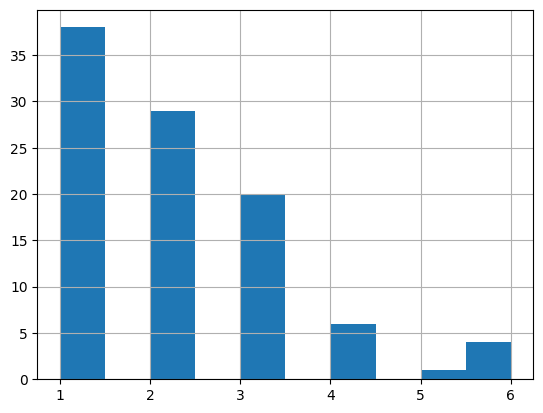

In [31]:
dataset["applicant_job_title"].value_counts().value_counts().hist()

In [32]:
dataset[["rule", "status"]].value_counts().reset_index()

,rule,status,count
0,Rule 6 (Invalid title),True,6089
1,Rule 4 (Hierarchy / seniority difference),False,2952
2,Rule 7 (Different job family),False,342
3,Rule 3 (Exact / near match),True,311
4,No rules matched,False,306


This dataset should suffice, apparently there's no need in enhancing it with more instances. \
The dataset is not ideal since it's easier to satisfy the positive rules that lead to `verified`.\
For this reason I added an option for prioritising the negative calss, which saturated dataset with 36%\
`discrepancy` class. This is optional, but, I believe, is useful for a generated dataset. 

# Task 2: Train a Binary Classification Model

## Features
There're were 2 approaches considered:
- Picking up on the same rules implemented in task 1
- Exploring vectorized versions of the texts

First approach not only seemed lazy, it would be a direct dataleak \
since the dataset is build on the very same deterministic rules, \
so fitting the model to them ould merely result in guessing the logical \
gates between the rules' outcomes. So in that in mind the rules column \
was dropped and no attempt of restoring the rules was made later on.

The second is a more interesting approach. I used SVD for dimension reduction, \
the SVD was picked over PCA for its better fit for sparse matrices. Plus, in \
optimal dense cases SVD can approximize PCA.

Then distance metrics. For them I used simple difference in tokens' numbers \
and in character lengths. Additionally, I used cosine similarity, but \
used a different one than before for two reasons: it's more interesting, \
and it wouldn't allow the model to directly fit to the 2 rules that are \
based on the cosine similarity. This similarity is calculated via vectorized texts. 


## Model
Francly, I simply chose the model architecture - a gradient boosting machine, \ 
and the worked towards what I used earlier less. But LightGBM has its advantages \
over per se CatBBoost in this particular case. LightGBM does not rely on categorical \
features, which CatBoost surely captures the best. LightGBM neither builds symmetric \
trees, whch allows it to build deeper dependencies, which might be better for the \
dataset with abstract features with reduced dimensions.

LightGBM is still small and easy to train locally, so it's easy to reproduce the \
results on any machine

## Results
In the lowest cells of this section you can see a short metricas report. \
the same is logged into mlflow, so if you run this notebook locally, \
you can see these metrics via running `mlflow ui` and following the localhost.

In the report we see that that F1 doesn't degrade too much on the test set, \
falling from `~0.99` to `~0.91` and we can see the other metrics reach decent \
values in `~0.9`'s.

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

from lightgbm import LGBMClassifier

RANDOM_STATE = 42
N_SPLITS = 5
EXPERIMENT_NAME = "job_title"
PREPROC_DIR = Path("./preprocessed")
ARTIFACTS_DIR = Path("./artifacts")
BEST_METRIC = "f1"

PREPROC_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)


def load_and_prepare_data(path: str | Path = Path("./dataset.csv")) -> pd.DataFrame:
    """Executes basic preprocessing steps.

    Parameters
    ----------
    path : str
        path to dataset

    Returns
    -------
    pd.DataFrame
        preprocessed dataset
    """
    df = pd.read_csv(path)
    if "rule" in df.columns:
        df = df.drop(columns=["rule"])

    df["status"] = df["status"].astype(int)
    df["target"] = df["status"]

    df["applicant_job_title"] = df["applicant_job_title"].fillna("").astype(str)
    df["official_record_job_title"] = (
        df["official_record_job_title"].fillna("").astype(str)
    )

    df.to_csv(PREPROC_DIR / "dataset.csv", index=False)
    return df


def build_features(
    df: pd.DataFrame, n_components: int = 50
) -> tuple[np.ndarray, np.ndarray]:
    """Includes feature engineering steps.

    Vectorizes text features, reduces dimensions, calculates titles'
    token and character difference, calculates cosine similarity and scales.

    Parameters
    ----------
    df : pd.DataFrame
        preprocessed dataset
    n_components : int, optional
        target number of components for SVD, by default 50

    Returns
    -------
    X, y: tuple[np.ndarray, np.ndarray]
        X for feaures and y for target
    """
    # Join titles and vectorize the together
    corpus = df["applicant_job_title"] + " ||| " + df["official_record_job_title"]
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2), min_df=2, max_df=0.9, strip_accents="unicode"
    )
    X_vec = vectorizer.fit_transform(corpus)

    # Here a PCA could be used, however it's suboptimal for the sparse data
    # that TFIDF vectorizer produces, so SVD is used instead.
    svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)
    X_svd = svd.fit_transform(X_vec)

    # Beside vectorized features, the token and character length's
    # difference can be used as features.
    len_diff = np.abs(
        df["applicant_job_title"].str.len() - df["official_record_job_title"].str.len()
    ).values.reshape(-1, 1)
    token_count_diff = np.abs(
        df["applicant_job_title"].str.split().str.len()
        - df["official_record_job_title"].str.split().str.len()
    ).values.reshape(-1, 1)

    # Cosine similarity between vectorized features of each job title
    title_vec = TfidfVectorizer(
        ngram_range=(1, 2), min_df=2, max_df=0.9, strip_accents="unicode"
    )
    title_vec.fit(
        list(df["applicant_job_title"]) + list(df["official_record_job_title"])
    )
    A = title_vec.transform(df["applicant_job_title"])
    B = title_vec.transform(df["official_record_job_title"])
    cos_vals = np.array(
        [
            (A[i].dot(B[i].T).data[0] if A[i].dot(B[i].T).nnz else 0.0)
            for i in range(A.shape[0])
        ]
    ).reshape(-1, 1)

    X = np.hstack([X_svd, len_diff, token_count_diff, cos_vals])
    y = df["target"].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y


def log_model_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray, scores: np.ndarray
) -> dict:
    """Log model evaluation metrics.

    Calculates metrics, combines them into a report and logs them.

    Parameters
    ----------
    y_test : np.ndarray
        original target values for the test set
    y_pred : np.ndarray
        predicted target values from the model for the test set
    y_proba : np.ndarray
        probabalistic predictions on the test set
    scores : np.ndarray
        cross-validation scores.

    Returns
    -------
    report : dict
        report of metric_name-metric mappings
    """
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    mcc = matthews_corrcoef(y_true, y_pred)

    metrics = {
        "cv_mean_f1": scores.mean(),
        "cv_std_f1": scores.std(),
        "test_prec": prec,
        "test_rec": rec,
        "test_f1": f1,
        "test_roc": roc,
        "test_pr_auc": pr_auc,
        "test_mcc": mcc,
    }

    for metric_name, metric in metrics.items():
        mlflow.log_metric(metric_name, metric)

    return metrics


def train_and_test(
    df_train: pd.DataFrame, df_test: pd.DataFrame
) -> tuple[LGBMClassifier, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict]:
    """Trains a LGBMClassifier, tests it and logs models and metrics in MLFlow.

    Enhances the dataset with engineered features, forms and fits a pipeline,
    tests it and logs metrics


    Parameters
    ----------
    df_train : pd.DataFrame
        preprocessed dataset
    df_test : pd.DataFrame
        ready-to-use target

    Returns
    -------
    tuple[LGBMClassifier, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict]
        Model, X_test, y_test, y_pred, y_proba, scores, metrics
    """

    mlflow.set_experiment(EXPERIMENT_NAME)

    X_train, y_train = build_features(df_train)
    X_test, y_test = build_features(df_test)

    # use pipeline for cross_val_score compatibility
    pipeline = Pipeline(
        steps=[
            (
                "model",
                LGBMClassifier(
                    n_estimators=300,
                    learning_rate=0.05,
                    max_depth=-1,
                    num_leaves=31,
                    class_weight="balanced",
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                    verbose=-1,
                ),
            ),
        ]
    )
    with mlflow.start_run(
        run_name="new_pipeline",
        log_system_metrics=True,
    ):
        cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1")
        pipeline.fit(X_train, y_train)

        # predict and log metrics
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.named_steps["model"].predict_proba(X_test)[:, 1]

        metrics = log_model_metrics(y_test, y_pred, y_proba, scores)

        mlflow.sklearn.log_model(pipeline, "model")

    return pipeline.named_steps["model"], X_test, y_test, y_pred, y_proba, scores, metrics


df = load_and_prepare_data("./dataset.csv")
df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df["target"], random_state=RANDOM_STATE
)

model, X_test, y_test, y_pred, y_proba, scores, metrics = train_and_test(df_train, df_test)

best_run = mlflow.search_runs(order_by=["metrics.cv_mean_f1 DESC"]).iloc[0]
mlflow.register_model(
    model_uri=f"runs:/{best_run.run_id}/model", name="LGBMClassifier_Job_Titles"
)

2025/10/23 22:18:09 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/10/23 22:18:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
d:\Productivity\recomboai_assignment\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Productivity\recomboai_assignment\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Productivity\recomboai_assignment\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Productivity\recomboai_assignment\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have 

<ModelVersion: aliases=[], creation_timestamp=1761250695317, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1761250695317, metrics=[<Metric: dataset_digest=None, dataset_name=None, key='cv_mean_f1', model_id='m-a6f31d6c72d143fea44795fe43c7c0f1', run_id='beea8a8c047c4055b392c75aee8a929f', step=0, timestamp=1761250690931, value=0.9990228647360704>,
 <Metric: dataset_digest=None, dataset_name=None, key='cv_std_f1', model_id='m-a6f31d6c72d143fea44795fe43c7c0f1', run_id='beea8a8c047c4055b392c75aee8a929f', step=0, timestamp=1761250690935, value=0.0012361705293300546>,
 <Metric: dataset_digest=None, dataset_name=None, key='test_f1', model_id='m-a6f31d6c72d143fea44795fe43c7c0f1', run_id='beea8a8c047c4055b392c75aee8a929f', step=0, timestamp=1761250690949, value=0.9127667540247099>,
 <Metric: dataset_digest=None, dataset_name=None, key='test_mcc', model_id='m-a6f31d6c72d143fea44795fe43c7c0f1', run_id='beea8a8c047c4055b392c75aee8a929f', step=0, timestamp

In [23]:
pd.Series(metrics)

cv_mean_f1     0.999023
cv_std_f1      0.001236
test_prec      0.876348
test_rec       0.952344
test_f1        0.912767
test_roc       0.923799
test_pr_auc    0.953821
test_mcc       0.744159
dtype: float64

# Task 3: Analyze Model Errors

From confusion matrix we see how the most prominent type of errors is False Positives.

More interesting is the fact that the FP accur primarily with higher proba. This means, \
that the errors happen exactly when the model is most sure of th correct positive result.\
This is shown on `Reliability diagram`, `Probability histograms`, and `PCA on features`.

We would typically call it an overfitting to the majority class, however PCA reveals how \
easy it is to separate reds from blues and especially reds from blacks. This means, there's \
a visually detectible hyperplane separating the major class of errors from correct answers.

This is not an overfitting, rather an underfitting or an excess of features, when the data is \
simpler than it is presented to the model.

So my next iteration would be experimenting with the following things:
- adding clusterization to the dataset
- reducing dimensionality even more
- trying CatBoost for categorical features with clusters in the dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import os
from sklearn.cluster import AgglomerativeClustering
import matplotlib.colors as mcolors

plt.rcParams.update({"figure.max_open_warning": 0})


def plot_confusion(y_true, y_pred, labels=[0, 1], ax=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title("Confusion matrix")
    return ax


def plot_roc_pr(y_true, y_proba, show_pr=True):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    fig, ax = (
        plt.subplots(1, 2, figsize=(12, 4))
        if show_pr
        else (plt.figure(figsize=(6, 4)), None)
    )
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    ax[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[0].set_title("ROC curve")
    ax[0].legend()

    if show_pr:
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        ap = average_precision_score(y_true, y_proba)
        ax[1].plot(recall, precision, label=f"AP={ap:.3f}")
        ax[1].set_xlabel("Recall")
        ax[1].set_ylabel("Precision")
        ax[1].set_title("Precision-Recall")
        ax[1].legend()
    plt.tight_layout()


def plot_probability_histograms(y_true, y_pred, y_proba, bins=25):
    # separate correct / incorrect and by true class
    correct = y_true == y_pred
    plt.figure(figsize=(10, 4))
    plt.hist(
        y_proba[correct & (y_true == 1)], bins=bins, alpha=0.6, label="correct pos (TP)"
    )
    plt.hist(
        y_proba[~correct & (y_true == 1)], bins=bins, alpha=0.8, label="wrong pos (FN)"
    )
    plt.hist(
        y_proba[correct & (y_true == 0)], bins=bins, alpha=0.6, label="correct neg (TN)"
    )
    plt.hist(
        y_proba[~correct & (y_true == 0)], bins=bins, alpha=0.8, label="wrong neg (FP)"
    )
    plt.xlabel("Predicted prob (class=1)")
    plt.legend()
    plt.title("Probability histograms")


def plot_reliability(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker="o", label="calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical probability")
    plt.title("Reliability diagram")
    plt.legend()


def plot_pca_space(
    X, y_true, y_pred, y_proba, n_components=2, random_state=0, save_path=None
):
    # 2D PCA visualisation
    # black dots for False positives with high proba > 0.9
    if hasattr(X, "toarray"):
        X_vis = X.toarray()
    else:
        X_vis = np.asarray(X)
    pca = PCA(n_components=n_components, random_state=random_state)
    Z = pca.fit_transform(X_vis)
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    correct = (y_true == y_pred).astype(int) * 2 + ((y_true == 0) & (y_proba > 0.9)).astype(int)
    norm = mcolors.CenteredNorm(vcenter=1, halfrange=1)
    sc = ax.scatter(
        Z[:, 0],
        Z[:, 1],
        c=correct.astype(int),
        cmap="berlin",
        norm=norm, 
        s=30 + 40 * y_proba,
        alpha=0.7,
    )
    ax.set_title("PCA of features. blue=wrong, red=correct, black=FP+proba>0.9, size=prob)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    return fig, ax, Z


def cluster_errors(
    X, y_true, y_pred, n_clusters, random_state=0, return_indices=False
):
    # cluster only misclassified rows
    mis_idx = np.where(y_true != y_pred)[0]
    if len(mis_idx) == 0:
        print("No misclassifications to cluster.")
        return None
    if hasattr(X, "toarray"):
        X_m = X.toarray()[mis_idx]
    else:
        X_m = np.asarray(X)[mis_idx]
    if n_clusters:
        n_clusters = min(n_clusters, max(2, len(mis_idx) // 10))
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        labels = kmeans.fit_predict(X_m)
    else:
        hc = AgglomerativeClustering(n_clusters=None, distance_threshold=2, linkage='ward')
        labels = hc.fit_predict(X_m)
    # return mapping cluster -> indices(in original X)
    clusters = {int(c): mis_idx[labels == c].tolist() for c in np.unique(labels)}
    if return_indices:
        return clusters
    return clusters


def detect_anomalies(X, contamination="auto", random_state=0):
    if hasattr(X, "toarray"):
        X_a = X.toarray()
    else:
        X_a = np.asarray(X)
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    pred = iso.fit_predict(X_a)  # -1 anomaly, 1 normal
    anomalies = np.where(pred == -1)[0]
    return anomalies, iso


def low_confidence_alerts(y_proba, threshold_low=0.4, threshold_high=0.6):
    """Return indices where model is uncertain and should be human-reviewed."""
    low_conf = np.where((y_proba > threshold_low) & (y_proba < threshold_high))[0]
    return low_conf


def run_full_analysis(
    X_test, y_test, y_pred, y_proba, outdir="./diagnostics", n_clusters=None, contamination="auto"
):
    os.makedirs(outdir, exist_ok=True)

    # basic visual diagnostics and metrics
    plot_confusion(y_test, y_pred)
    plt.savefig(os.path.join(outdir, "confusion_matrix.png"), bbox_inches="tight")

    plot_roc_pr(y_test, y_proba)
    plt.savefig(os.path.join(outdir, "roc_pr.png"), bbox_inches="tight")

    plot_probability_histograms(y_test, y_pred, y_proba)
    plt.savefig(os.path.join(outdir, "prob_hist.png"), bbox_inches="tight")

    plot_reliability(y_test, y_proba)
    plt.savefig(os.path.join(outdir, "reliability.png"), bbox_inches="tight")

    # 2) PCA visualization
    fig, ax, Z = plot_pca_space(
        X_test, y_test, y_pred, y_proba, save_path=os.path.join(outdir, "pca_space.png")
    )

    # errored samples clustered
    clusters = cluster_errors(X_test, y_test, y_pred, n_clusters=n_clusters, return_indices=True)
    if clusters:
        cluster_summary = {
            c: {"count": len(idxs), "sample_indices": idxs[:5]}
            for c, idxs in clusters.items()
        }
        pd.DataFrame.from_dict(cluster_summary, orient="index").to_csv(
            os.path.join(outdir, "cluster_summary.csv")
        )

    # anomaly detection with isolation forest
    anomalies, iso = detect_anomalies(X_test, contamination=contamination)
    pd.DataFrame({"anomaly_index": anomalies}).to_csv(
        os.path.join(outdir, "anomalies.csv"), index=False
    )

    # samples with low confidence in proba
    lowconf_idx = low_confidence_alerts(y_proba, 0.4, 0.6)
    pd.DataFrame({"low_confidence_index": lowconf_idx}).to_csv(
        os.path.join(outdir, "low_confidence.csv"), index=False
    )

    print("Diagnostics saved to", outdir)
    return {
        "clusters": clusters,
        "anomalies": anomalies,
        "low_conf_indices": lowconf_idx,
    }

Diagnostics saved to ./diagnostics


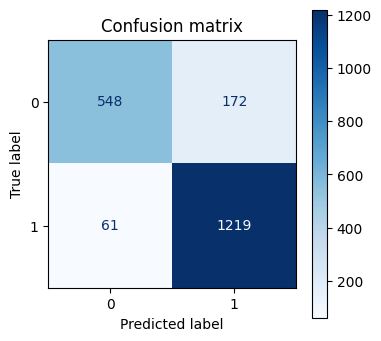

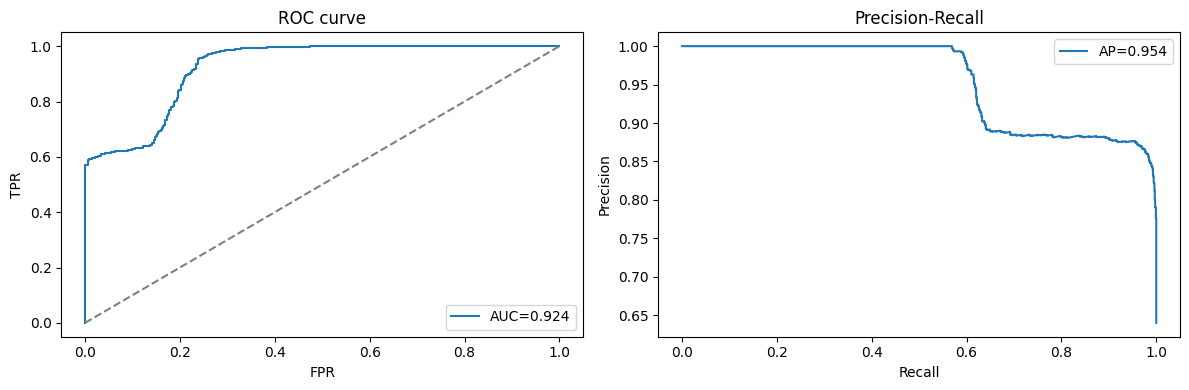

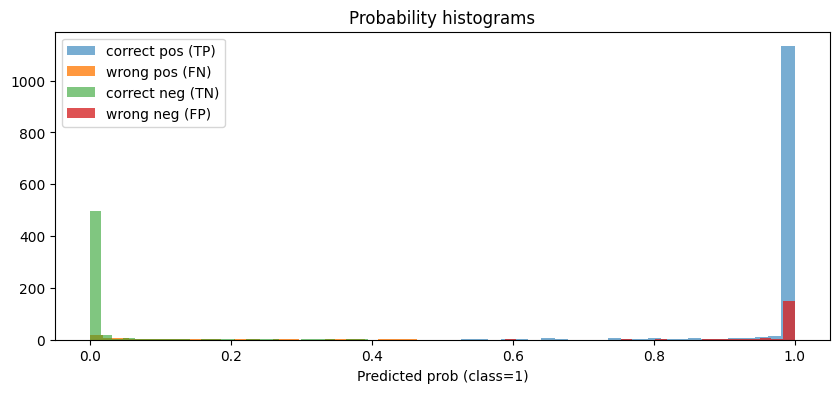

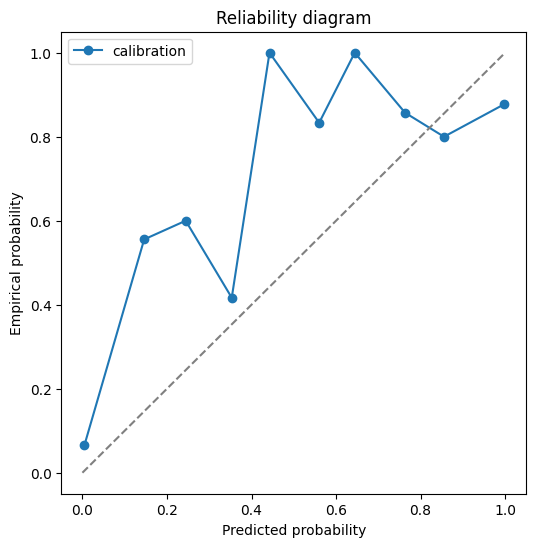

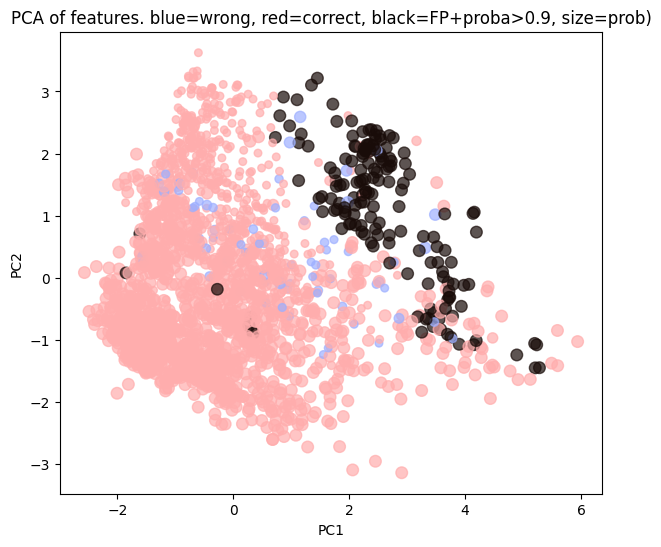

In [50]:
_ = run_full_analysis( X_test, y_test, y_pred, y_proba, outdir='./diagnostics')

# Epilogue

This concludes my test assignment. Couple of things I would love to improve in this solution:
- **Deterministic rules are naive**. They are great for demonstratyional purposes, but be it an industrial case \
 I would first need more marked data for NER, since few of open source pretrained models were satisfactory to \
 my taste.
- **Model selection**. As described in Task 3, I found several weak points of the trained model, and proposed \
steps to improvement.
- **Format**. It was required to put the solution into a notebook, but realistically experiments would become \
much easier with properly managed code separation. I'll probably tidy it up and build a better structured repo \
for the experiment tracking.



**Thank you for the assignment and your time checking it, have a great time!**